<a href="https://colab.research.google.com/github/cccg8105/notebook_AD/blob/master/Analisis/Frecuencia%20inscripciones/NuevasInscripciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis de inscripciones

## Importación de datos

In [18]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()

# carga de archivo
raw_csv_data_CL = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_CL.csv")
raw_csv_data_CO = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_CO.csv")
raw_csv_data_DO = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_DO.csv")
raw_csv_data_EC = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_EC.csv")
raw_csv_data_MX = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_MX.csv")
raw_csv_data_PA = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_PA.csv")
raw_csv_data_PE = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_PE.csv")
raw_csv_data_SV = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_SV.csv")



## Estructura y formateo de datos

In [19]:
dateColumnName = "Fecha"
analizedValue = "cantidad"

unused_columns = ['cantidad','FuenteIngreso']

df_comp = pd.concat([raw_csv_data_CL, raw_csv_data_CO, raw_csv_data_DO, raw_csv_data_EC, raw_csv_data_MX, raw_csv_data_PA, raw_csv_data_PE, raw_csv_data_SV])

# formateo de fecha 
df_comp[dateColumnName] = pd.to_datetime(df_comp.Fecha, dayfirst = True)
df_comp = df_comp.groupby([dateColumnName,'FuenteIngreso']).sum().reset_index()
df_comp_UB = df_comp[df_comp.FuenteIngreso == "UB"]

df_comp_UB.set_index(dateColumnName, inplace=True, verify_integrity=True)
df_comp_UB=df_comp_UB.asfreq('d')
df_comp_UB=df_comp_UB.fillna(method='ffill')

df_comp_UB['analizedValue'] = df_comp_UB[analizedValue]

df_comp_UB = df_comp_UB.drop(unused_columns, axis=1)
df_comp_UB.head(5)

,analizedValue
Fecha,
2018-01-02,8
2018-01-03,20
2018-01-04,39
2018-01-05,55
2018-01-06,8


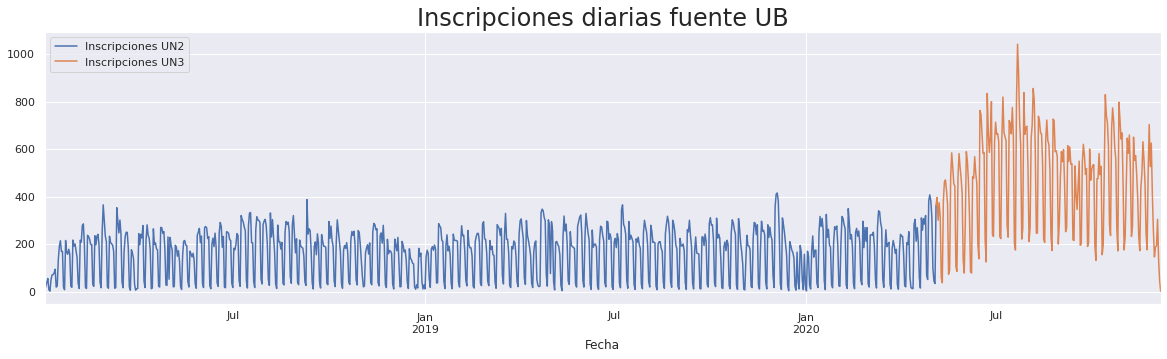

In [20]:
df_comp_UB.analizedValue[:'2020-05-04'].plot(figsize = (20,5), label='Inscripciones UN2')
df_comp_UB.analizedValue['2020-05-04':].plot(figsize = (20,5), label='Inscripciones UN3')
plt.title("Inscripciones diarias fuente UB", size= 24)
plt.legend(loc='upper left')
plt.show()

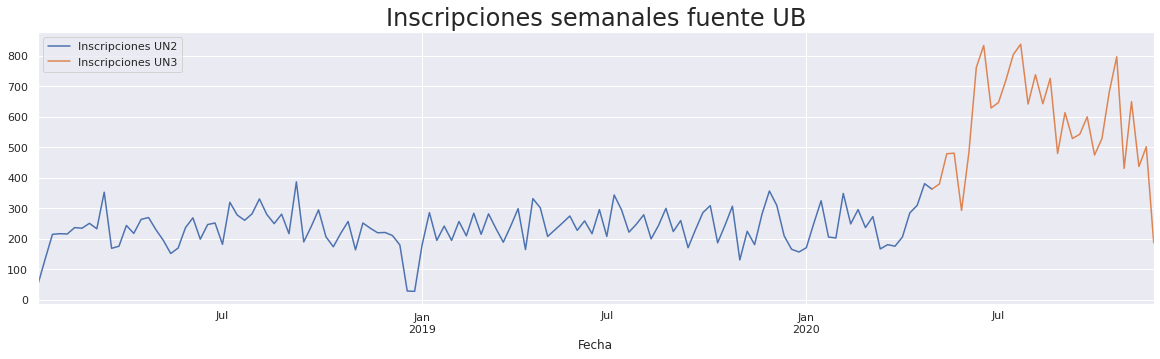

In [21]:
df_comp_UB_w=df_comp_UB.asfreq('W-Mon')

df_comp_UB_w.analizedValue[:'2020-05-04'].plot(figsize = (20,5), label='Inscripciones UN2')
df_comp_UB_w.analizedValue['2020-05-04':].plot(figsize = (20,5), label='Inscripciones UN3')
plt.title("Inscripciones semanales fuente UB", size= 24)
plt.legend(loc='upper left')
plt.show()

## Prueba de estacionalidad

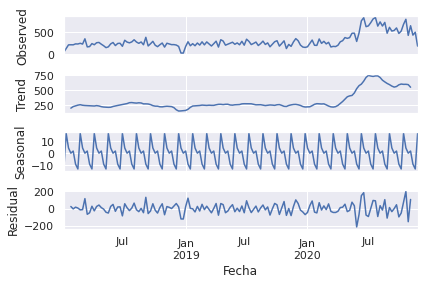

In [100]:
frecuencia = 6

s_dec_additive = seasonal_decompose(df_comp_UB_w.analizedValue, "additive", freq=frecuencia)
s_dec_additive.plot()
plt.show()

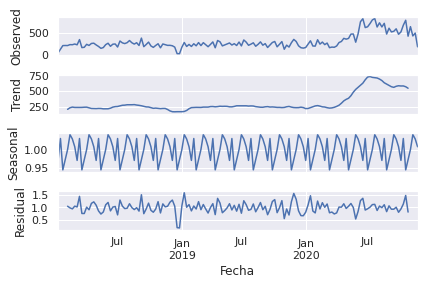

In [6]:
s_dec_multiplicative = seasonal_decompose(df_comp_UB_w.analizedValue, "multiplicative", freq=frecuencia)
s_dec_multiplicative.plot()
plt.show()

## División en entrenamiento y prueba

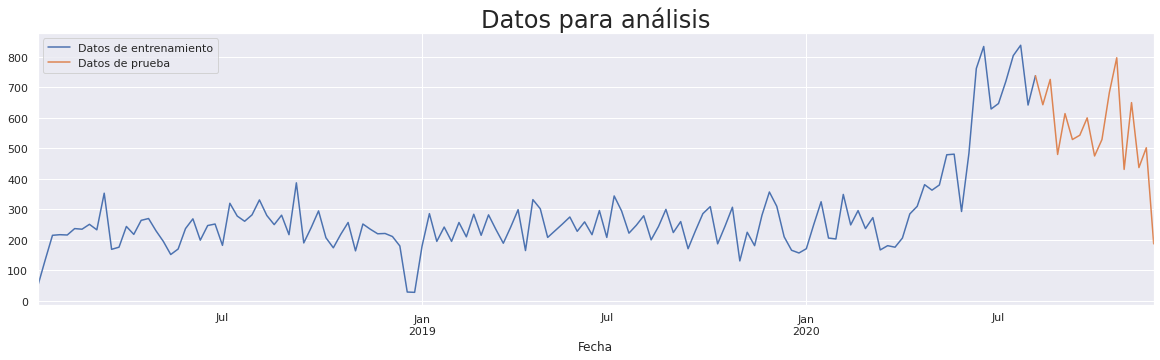

In [7]:
porcentajeEntrenamiento = 0.9
size = int(len(df_comp_UB_w)*porcentajeEntrenamiento)
df_train, df_test = df_comp_UB_w.iloc[:size], df_comp_UB_w.iloc[size-1:]

df_train.analizedValue.plot(figsize = (20,5), label='Datos de entrenamiento')
df_test.analizedValue.plot(figsize = (20,5), label='Datos de prueba')
plt.title("Datos para análisis", size= 24)
plt.legend(loc='upper left')
plt.show()

## Pronóstico con libreria Prophet

### Adecuación de datos

In [7]:
import pandas as pd
from fbprophet import Prophet

dftrain_profet = df_train.reset_index()
dftrain_profet.columns = ['ds','y']
dftrain_profet['ds'] = pd.to_datetime(dftrain_profet['ds'])
dftrain_profet.sample(5)


,ds,y
1,2018-01-15,133
127,2020-06-15,762
53,2019-01-14,286
76,2019-06-24,296
4,2018-02-05,216


### Entrenamiento

In [8]:
additiveModel = Prophet(interval_width=0.95, seasonality_mode='additive')
additiveModel.fit(dftrain_profet)

multiplicativeModel = Prophet(interval_width= 0.95, seasonality_mode='multiplicative')
multiplicativeModel.fit(dftrain_profet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Resultados modelo aditivo

In [9]:
# Generar fechas futuras en base a los datos de prueba
future = additiveModel.make_future_dataframe(periods=len(df_test),freq = 'W-Mon') # 2 años adicionales

forecast = additiveModel.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
148,2020-11-09,611.011733,420.861185,717.504559,602.320537,621.346312,-45.690984,-45.690984,-45.690984,-45.690984,-45.690984,-45.690984,0.0,0.0,0.0,565.320749
149,2020-11-16,618.163086,444.957308,735.261645,608.500214,629.405021,-29.200261,-29.200261,-29.200261,-29.200261,-29.200261,-29.200261,0.0,0.0,0.0,588.962825
150,2020-11-23,625.314440,480.488683,770.502484,614.356006,637.835617,5.709599,5.709599,5.709599,5.709599,5.709599,5.709599,0.0,0.0,0.0,631.024039
151,2020-11-30,632.465793,515.845609,798.918036,620.552071,645.670584,29.752270,29.752270,29.752270,29.752270,29.752270,29.752270,0.0,0.0,0.0,662.218062
152,2020-12-07,639.617146,500.627388,804.541742,626.799206,654.163020,11.289907,11.289907,11.289907,11.289907,11.289907,11.289907,0.0,0.0,0.0,650.907053


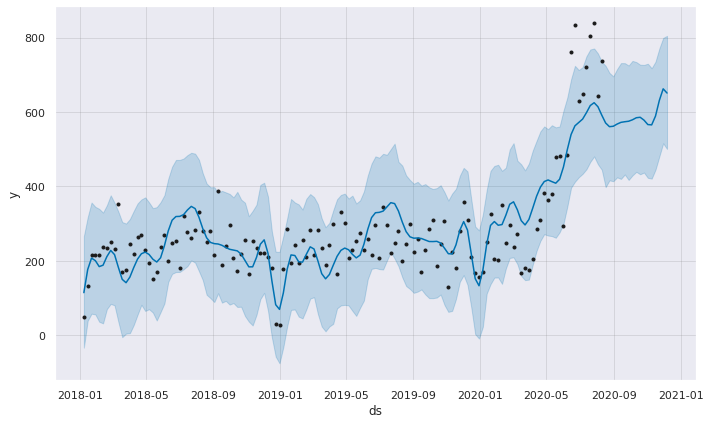

In [10]:
additiveModel.plot(forecast);

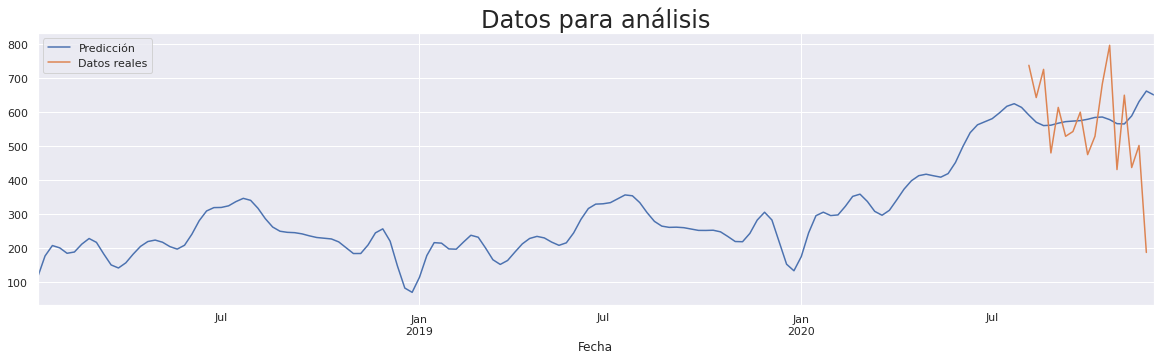

In [11]:
dfrestult = forecast[['ds', 'yhat']]
dfrestult.columns = ['Fecha', 'analizedValue']
dfrestult.set_index('Fecha', inplace=True, verify_integrity=True)

dfrestult.analizedValue.plot(figsize = (20,5), label='Predicción')
df_test.analizedValue.plot(figsize = (20,5), label='Datos reales')
plt.title("Datos para análisis", size= 24)
plt.legend(loc='upper left')
plt.show()

### Resultados modelo multiplicativo

In [12]:
# Generar fechas futuras en base a los datos de prueba
future = multiplicativeModel.make_future_dataframe(periods=len(df_test),freq = 'W-Mon') # 2 años adicionales

forecast = multiplicativeModel.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
148,2020-11-09,578.200828,349.160420,587.508119,569.235130,587.135916,-0.196324,-0.196324,-0.196324,-0.196324,-0.196324,-0.196324,0.0,0.0,0.0,464.686250
149,2020-11-16,584.473033,384.539310,637.654462,574.455571,594.183844,-0.119531,-0.119531,-0.119531,-0.119531,-0.119531,-0.119531,0.0,0.0,0.0,514.610244
150,2020-11-23,590.745237,477.244694,726.202565,579.651193,601.604836,0.018187,0.018187,0.018187,0.018187,0.018187,0.018187,0.0,0.0,0.0,601.489341
151,2020-11-30,597.017441,545.348836,786.657638,584.662263,608.648235,0.108557,0.108557,0.108557,0.108557,0.108557,0.108557,0.0,0.0,0.0,661.827969
152,2020-12-07,603.289645,500.676625,755.884587,589.665991,615.906097,0.040633,0.040633,0.040633,0.040633,0.040633,0.040633,0.0,0.0,0.0,627.803264


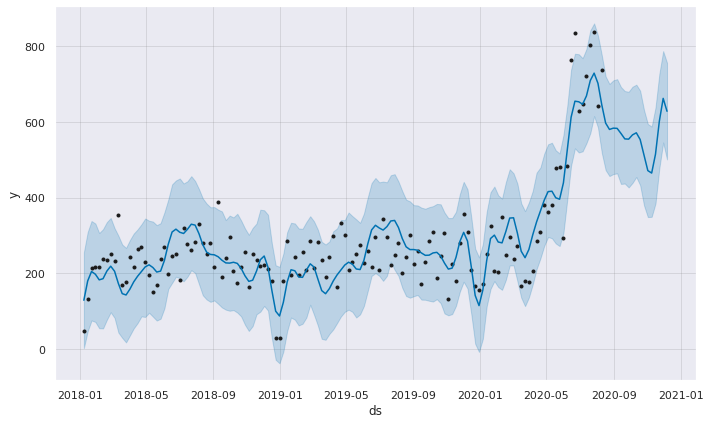

In [13]:
multiplicativeModel.plot(forecast);

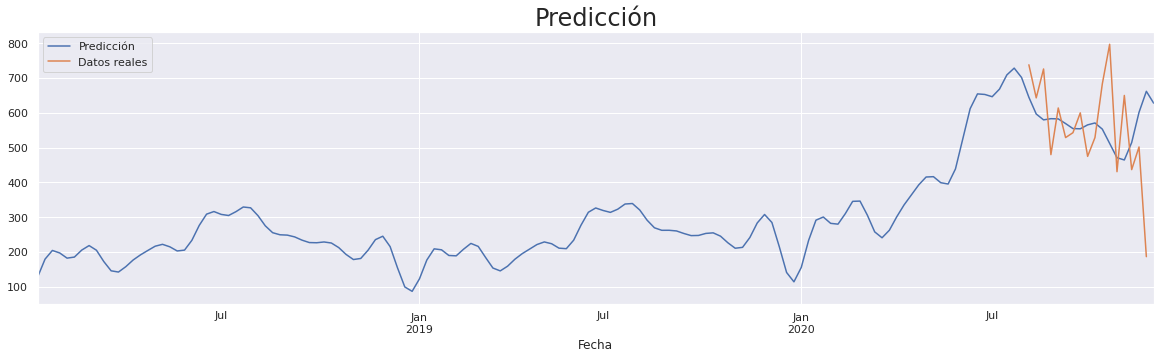

In [14]:
dfrestult = forecast[['ds', 'yhat']]
dfrestult.columns = ['Fecha', 'analizedValue']
dfrestult.set_index('Fecha', inplace=True, verify_integrity=True)

dfrestult.analizedValue.plot(figsize = (20,5), label='Predicción')
df_test.analizedValue.plot(figsize = (20,5), label='Datos reales')
plt.title("Predicción", size= 24)
plt.legend(loc='upper left')
plt.show()

## Pronóstico con RNN

### Escalado de datos

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_train)

scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

print(len(scaled_train))
vartrain = [scaled_train[i] - scaled_train[i - 12] for i in range(12, len(scaled_train))]
print(len(vartrain))

136
124


In [30]:
n_input = [12]
n_nodes = [50, 100]
n_epochs = [100]
n_batch = [1, 150]
n_diff = [0, 12]
# create configs
configs = list()
for i in n_input:
	for j in n_nodes:
		for k in n_epochs:
			for l in n_batch:
				for m in n_diff:
					cfg = [i, j, k, l, m]
					configs.append(cfg)
print(configs)

[[12, 50, 100, 1, 0], [12, 50, 100, 1, 12], [12, 50, 100, 150, 0], [12, 50, 100, 150, 12], [12, 100, 100, 1, 0], [12, 100, 100, 1, 12], [12, 100, 100, 150, 0], [12, 100, 100, 150, 12]]


### Creación de generators


In [9]:

from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 4 # este valor deberia depender del valor estacional
n_features = 1
generator1 = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

print(len(generator1)) # n_input = 2

X,y = generator1[0]

print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

n_input = 6 # este valor deberia depender del valor estacional
n_features = 1
generator2 = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

print(len(generator2)) # n_input = 2

X,y = generator2[0]

print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')


n_input = 8 # este valor deberia depender del valor estacional
n_features = 1
generator3 = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

print(len(generator3)) # n_input = 2

X,y = generator3[0]

print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

n_input = 10 # este valor deberia depender del valor estacional
n_features = 1
generator4 = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

print(len(generator4)) # n_input = 2

X,y = generator4[0]

print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

132
Datos: 
[0.02469136 0.12962963 0.2308642  0.23333333]
Predicción: 
 [[0.23209877]]
130
Datos: 
[0.02469136 0.12962963 0.2308642  0.23333333 0.23209877 0.25802469]
Predicción: 
 [[0.25555556]]
128
Datos: 
[0.02469136 0.12962963 0.2308642  0.23333333 0.23209877 0.25802469
 0.25555556 0.27530864]
Predicción: 
 [[0.25308642]]
126
Datos: 
[0.02469136 0.12962963 0.2308642  0.23333333 0.23209877 0.25802469
 0.25555556 0.27530864 0.25308642 0.40123457]
Predicción: 
 [[0.17407407]]


### Creacion de datos de entrada (sin generator)

In [16]:
X_train = []
y_train = []

periodosPasados = 4
periodosTotales = len(scaled_train)

for i in range(periodosPasados, periodosTotales):
    X_train.append(scaled_train[i-periodosPasados:i, 0])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Se agrega nueva dimension a la matriz en caso de colocar mas variables al modelo
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train)
print(X_train.shape[1])

[[[0.02469136]
  [0.12962963]
  [0.2308642 ]
  [0.23333333]]

 [[0.12962963]
  [0.2308642 ]
  [0.23333333]
  [0.23209877]]

 [[0.2308642 ]
  [0.23333333]
  [0.23209877]
  [0.25802469]]

 [[0.23333333]
  [0.23209877]
  [0.25802469]
  [0.25555556]]

 [[0.23209877]
  [0.25802469]
  [0.25555556]
  [0.27530864]]

 [[0.25802469]
  [0.25555556]
  [0.27530864]
  [0.25308642]]

 [[0.25555556]
  [0.27530864]
  [0.25308642]
  [0.40123457]]

 [[0.27530864]
  [0.25308642]
  [0.40123457]
  [0.17407407]]

 [[0.25308642]
  [0.40123457]
  [0.17407407]
  [0.18271605]]

 [[0.40123457]
  [0.17407407]
  [0.18271605]
  [0.26666667]]

 [[0.17407407]
  [0.18271605]
  [0.26666667]
  [0.2345679 ]]

 [[0.18271605]
  [0.26666667]
  [0.2345679 ]
  [0.29135802]]

 [[0.26666667]
  [0.2345679 ]
  [0.29135802]
  [0.29876543]]

 [[0.2345679 ]
  [0.29135802]
  [0.29876543]
  [0.24938272]]

 [[0.29135802]
  [0.29876543]
  [0.24938272]
  [0.20617284]]

 [[0.29876543]
  [0.24938272]
  [0.20617284]
  [0.15308642]]

 [[0.249

### Modelo 1: Con una sola capa

#### Creación del modelo con gridsearch

Para optimización de hiperparametros

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

n_input = periodosPasados
def build_classifier(optimizer):
  model = Sequential()
  model.add(LSTM(units=100, return_sequences = False, activation='relu', input_shape=(n_input, n_features)))
  model.add(Dense(1))
  model.compile(optimizer=optimizer, loss='mse',metrics=["accuracy"])
  return model

classifier = KerasClassifier(build_fn = build_classifier)

rangoLotes = [10,50]
rangoEpocas = [100, 200, 300]
optimizadores = ['adam', 'rmsprop','SGD']
parameters = {
    'batch_size' : rangoLotes,
    'nb_epoch' : rangoEpocas, 
    'optimizer' : optimizadores
}

grid_search = GridSearchCV(estimator = classifier, 
                           param_grid = parameters, 
                           scoring = 'accuracy')

grid_search = grid_search.fit(X_train, y_train)

best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(best_parameters)
print(best_accuracy)

11/11 [==============================] - 1s 3ms/step - loss: 2393.4530 - accuracy: 0.0033 


ValueError: ignored

In [45]:
from math import sqrt
from numpy import mean
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
  periodosTotales = len(data)
  X_train = []
  y_train = []

  for i in range(n_in, periodosTotales):
      X_train.append(scaled_train[i-n_in:i, 0])
      y_train.append(scaled_train[i, 0])
  X_train, y_train = np.array(X_train), np.array(y_train)
  # Se agrega nueva dimension a la matriz en caso de colocar mas variables al modelo
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_out))
  return X_train, y_train

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch = config
	# transform series into supervised format
	train_x, train_y = series_to_supervised(train, n_in=n_input)
	# define model
	model = Sequential()
	model.add(LSTM(units=n_nodes, return_sequences = False, activation='relu', input_shape=(n_input, 1)))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  n_input, n_nodes, n_epochs, n_batch = cfg
  predictions = list()
  train, test = data[0], data[1]
	# fit model
  model = model_fit(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  first_eval_batch = train[-n_input:]
  current_batch = first_eval_batch.reshape((1, n_input, n_features))
  test_predictions = []
  for i in range(len(df_test)):      
      # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
      current_pred = model.predict(current_batch)[0]      
      # guardar la predicción
      test_predictions.append(current_pred)
      # actualizar el lote para incluir ahora la predicción y soltar primer valor
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
  # Conversion de datos escalados al valor original
  true_predictions = scaler.inverse_transform(test_predictions)
  error = measure_rmse(test, true_predictions)
  print(' > %.3f' % error)
  return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [4,8,10,12]
	n_nodes = [10, 50, 100]
	n_epochs = [100, 200, 300]
	n_batch = [10, 20, 50]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					cfg = [i, j, k, l]
					configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

n_test = 12
# model configs
cfg_list = model_configs()

data = [scaled_train, df_test]
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
	print(cfg, error)

Total configs: 108
 > 577.118
 > 1037.496
 > 4815.375
 > 403.164
 > 1329.646
 > 517.747
 > 7677.227
 > 789.981
 > 848.046
 > 869.536
> Model[[4, 10, 100, 10]] 1886.534
 > 905.128
 > 569.326
 > 971.863
 > 373.430
 > 391.007
 > 521.057
 > 778.382
 > 8734.584
 > 347.439
 > 312.598
> Model[[4, 10, 100, 20]] 1390.481
 > 1853.931
 > 787.554
 > 225.268
 > 396.204
 > 437.036
 > 476.844
 > 474.043
 > 610.624
 > 2343.312
 > 221.302
> Model[[4, 10, 100, 50]] 782.612
 > 1626.056
 > 350.123
 > 2234.187
 > 283.041
 > 399.151
 > 6244.170
 > 387.101
 > 327.759
 > 325.652
 > 825.206
> Model[[4, 10, 200, 10]] 1300.245
 > 2848.764
 > 1805.549
 > 333.677
 > 443.440
 > 360.775
 > 7143.123
 > 870.695
 > 4277.070
 > 482.111
 > 1025.188
> Model[[4, 10, 200, 20]] 1959.039
 > 1109.476
 > 3707.437
 > 2257.571
 > 431.946
 > 599.012
 > 755.434
 > 660.918
 > 3021.911
 > 436.816
 > 5865.102
> Model[[4, 10, 200, 50]] 1884.562
 > 237.341
 > 287.725
 > 395.526
 > 1540.995
 > 306.938
 > 283.185
 > 628.430
 > 603.027
 > 

### Entrenamiento

In [111]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


# creacion del modelo
model = Sequential()
#Primera capa
model.add(LSTM(units=100, return_sequences = False, activation='relu', input_shape=(n_input, n_features)))
#ratioDesactivacionNodos = 0.2
#model.add(Dropout(ratioDesactivacionNodos))



# entrenamiento
model.fit_generator(generator,epochs=300, steps_per_epoch= 25)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
25/25 [==============================] - 1s 3ms/step - loss: 0.0982 - accuracy: 0.0000e+00
Epoch 2/300
25/25 [==============================] - 0s 3ms/step - loss: 0.0661 - accuracy: 0.0000e+00
Epoch 3/300
25/25 [==============================] - 0s 3ms/step - loss: 0.0197 - accuracy: 0.0000e+00
Epoch 4/300
25/25 [==============================] - 0s 3ms/step - loss: 0.0048 - accuracy: 0.0000e+00
Epoch 5/300
25/25 [==============================] - 0s 3ms/step - loss: 0.0118 - accuracy: 0.

### Resultados

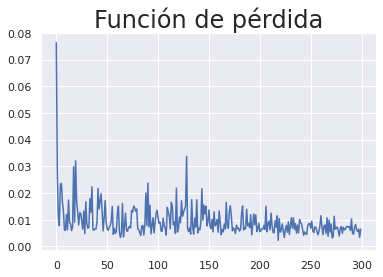

In [112]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title("Función de pérdida", size= 24)
plt.show()

In [104]:
df_test.iloc[:].values

array([[738],
       [643],
       [726],
       [480],
       [614],
       [529],
       [543],
       [600],
       [475],
       [529],
       [683],
       [797],
       [431],
       [650],
       [437],
       [502],
       [187]])

In [113]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Conversion de datos escalados al valor original
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

import math
from sklearn.metrics import mean_squared_error

# Error cuadratico medio
rmse = math.sqrt(mean_squared_error(df_test.iloc[:].values, true_predictions))
rango = max(df_test.iloc[:].values) - min(df_test.iloc[:].values)
print(rmse/rango)



[0.36740855]


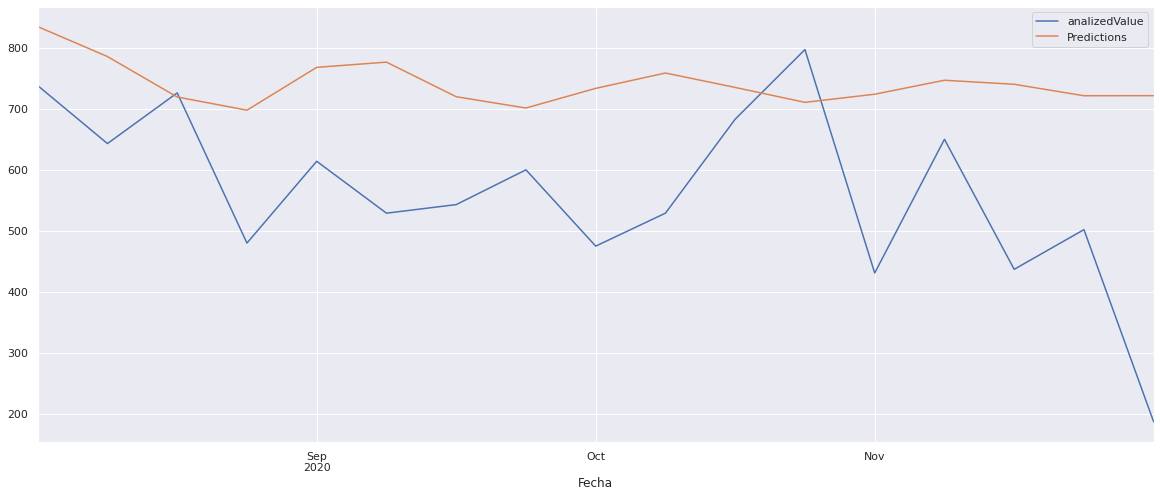

In [114]:
result = df_test.copy()
result['Predictions'] = true_predictions
result.plot(figsize=(20,8))